In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.metrics import log_loss
from sklearn.metrics import average_precision_score as aps
from sklearn.metrics import roc_auc_score as auc

In [4]:
df = pd.read_csv('train.csv')

In [5]:
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [6]:
feature_list = list(df.columns)
feature_list.remove('ID_code')
feature_list.remove('target')

X = df[feature_list].values
y = df['target'].values

In [7]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size = 0.3)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size = 0.2)

In [8]:
import lightgbm as lgb

In [9]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

lgbm_params = {
    'objective': 'binary',
    'num_leaves': 24,
}

# 上記のパラメータでモデルを学習する
model = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_val, num_boost_round=100)

[1]	valid_0's binary_logloss: 0.320799
[2]	valid_0's binary_logloss: 0.317694
[3]	valid_0's binary_logloss: 0.315047
[4]	valid_0's binary_logloss: 0.312684
[5]	valid_0's binary_logloss: 0.310357
[6]	valid_0's binary_logloss: 0.308134
[7]	valid_0's binary_logloss: 0.30614
[8]	valid_0's binary_logloss: 0.304197
[9]	valid_0's binary_logloss: 0.302399
[10]	valid_0's binary_logloss: 0.300491
[11]	valid_0's binary_logloss: 0.298763
[12]	valid_0's binary_logloss: 0.297238
[13]	valid_0's binary_logloss: 0.295682
[14]	valid_0's binary_logloss: 0.294211
[15]	valid_0's binary_logloss: 0.292892
[16]	valid_0's binary_logloss: 0.291525
[17]	valid_0's binary_logloss: 0.290443
[18]	valid_0's binary_logloss: 0.289218
[19]	valid_0's binary_logloss: 0.287917
[20]	valid_0's binary_logloss: 0.286639
[21]	valid_0's binary_logloss: 0.285491
[22]	valid_0's binary_logloss: 0.284388
[23]	valid_0's binary_logloss: 0.283311
[24]	valid_0's binary_logloss: 0.282243
[25]	valid_0's binary_logloss: 0.281057
[26]	valid

In [10]:
ctr_train = np.array(y_train).mean()

In [11]:
# テストデータを予測する
def evals(X, y_true, ctr_train):
    y_pred = model.predict(X)
    y_pred_post = y_pred / (y_pred  +  (1 - ctr_train) / ctr_train  * (1 - y_pred) )
    print('logloss: %.4f' % log_loss(y_true, y_pred))
    print('logloss_post: %.4f' % log_loss(y_true, y_pred_post))
    print('auc: %.4f' % auc(y_true, y_pred))
    print('norm aps:  %.4f' % (aps(y_true, y_pred)/y_true.mean()))

In [12]:
print('-'*10)
evals(X_train, y_train, ctr_train)
print('-'*10)
evals(X_val, y_val, ctr_train)
print('-'*10)
evals(X_test, y_test, ctr_train)

----------
logloss: 0.2089
logloss_post: 0.3280
auc: 0.9282
norm aps:  7.1350
----------
logloss: 0.2407
logloss_post: 0.3632
auc: 0.8649
norm aps:  5.1758
----------
logloss: 0.2441
logloss_post: 0.3666
auc: 0.8588
norm aps:  4.9957


In [13]:
def gen_plot_points(X, y_true, num_points=100):
    y_pred = model.predict(X) 
    scores = []
    ctrs = []
    delta = 1 / num_points
    for i in range(num_points):
        mask = (y_pred >= delta * i) * (y_pred < delta * (i +1))
        if mask.sum() > 0:
            scores.append(y_pred[mask].mean())
            ctrs.append(y_true[mask].mean())
    return scores, ctrs

In [14]:
scores_train, ctrs_train  =  gen_plot_points(X_train, y_train)
scores_val, ctrs_val  =  gen_plot_points(X_val, y_val)
scores_test, ctrs_test  =  gen_plot_points(X_test, y_test)

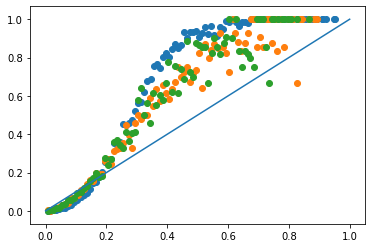

In [15]:
plt.scatter(scores_train, ctrs_train)
plt.scatter(scores_test, ctrs_test)
plt.scatter(scores_val, ctrs_val )

plt.plot([0,1], [0,1])
plt.show()

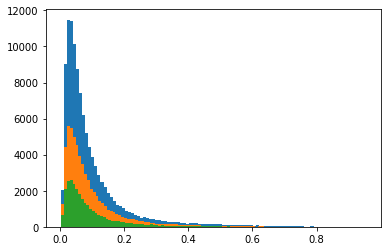

In [16]:
plt.hist(model.predict(X_train) , bins=100)
plt.hist(model.predict(X_test) , bins=100)
plt.hist(model.predict(X_val) , bins=100)
plt.show()

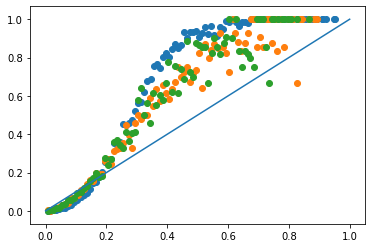

In [17]:
plt.scatter(scores_train, ctrs_train)
plt.scatter(scores_test, ctrs_test)
plt.scatter(scores_val, ctrs_val )

plt.plot([0,1], [0,1])
plt.show()

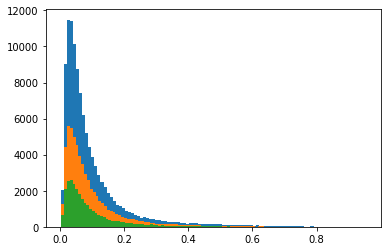

In [18]:
plt.hist(model.predict(X_train) , bins=100)
plt.hist(model.predict(X_test) , bins=100)
plt.hist(model.predict(X_val) , bins=100)
plt.show()

In [19]:
def post(scores, ctr_train):
    s_prev = np.array(scores)
    return s_prev / (s_prev  +  (1 - ctr_train) / ctr_train  * (1 - s_prev) )

In [20]:
s_post_train = post(scores_train, ctr_train)
s_post_val = post(scores_val, ctr_train)
s_post_test = post(scores_test, ctr_train)

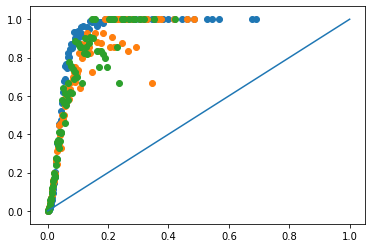

In [21]:
plt.scatter(s_post_train, ctrs_train)
plt.scatter(s_post_test, ctrs_test)
plt.scatter(s_post_val, ctrs_val )

plt.plot([0,1], [0,1])
plt.show()